# Dimensionality Reduction

This notebook evaluates methods for dimensionality reduction using the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump.

## Table of Contents
* [Data Import](#data_import)
* [Dimensionality Reduction Methods](#methods)

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import math
import time
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
data_folder = Path(MODELS_PATH + '/dimension_reduction')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data_import'/>

## Data Import

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.tokenizer import BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer
from academia_tag_recommender.vectorizer_computation import get_vect_feat_with_params
from academia_tag_recommender.documents import documents

texts = [document.text for document in documents]

[vectorizer, features] = get_vect_feat_with_params(texts, TfidfVectorizer, BasicTokenizer, BasicPreprocessor, None, (1, 1))

Received saved model


## Data Preparation

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

label = [document.tags for document in documents]

X = features
print('X data with shape {}'.format(X.shape))

y = MultiLabelBinarizer().fit_transform(label)
print('Y data with shape {}'.format(y.shape))

X data with shape (33082, 22079)
Y data with shape (33082, 452)


<a id='methods'/>

## Dimensionality Reduction Methods

from scikit-learn:
- [Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
- [Decomposition](https://scikit-learn.org/stable/modules/decomposition.html#lsa)
    - [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD), [Explanation](https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis), [Example](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)
- [Dimensionality Reduction](https://scikit-learn.org/stable/modules/lda_qda.html#dimensionality-reduction-using-linear-discriminant-analysis)
    - [LDA](https://scikit-learn.org/stable/modules/lda_qda.html#dimensionality-reduction-using-linear-discriminant-analysis)

from literature:
- [CHI](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html), [Explanation](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
- [Information Gain](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif), [Example](https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn)
- LSA (using TruncatedSVD), [Example](https://github.com/chrisjmccormick/LSA_Classification/blob/master/runClassification_LSA.py)
- [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

**CHI**

[Chi-squared](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) is a statistic measure for dependence between variables. Based on the chi2 statistic the *k* best [univariate features](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) are selected using [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

begin = time.time()

K = 1000
selector = SelectKBest(chi2, k=K)
X_new = selector.fit_transform(X, y)

time.sleep(1)
end = time.time()
time_passed = end - begin

print('Time with k = {}:{:<5} {:.3f} ms'.format(K, '', time_passed))

Outputs for different *K*:

`Time with K = 2:      3.744 s`

`Time with K = 100:    3.909 s`

`Time with K = 1000:   4.129 s`

Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

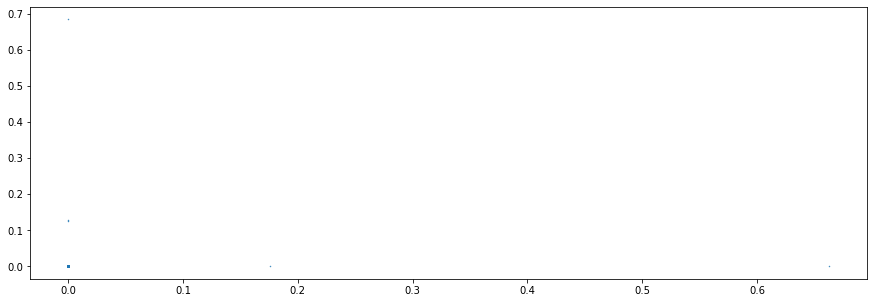

In [9]:
K = 2

selector = SelectKBest(chi2, k=K)
X_new = selector.fit_transform(X, y)
X_new = X_new.toarray()

plt.figure(figsize=(15,5))
plt.scatter(X_new[:,0], X_new[:,1], s=0.2)
plt.show()

**Information Gain**

[Mutual information gain](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) is a statistic measure for dependence between variables. Based on the information gain statistic the *k* best [univariate features](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) are selected using [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).

In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# does not work for multilabel
# selector = SelectKBest(mutual_info_classif, k=n)
# X_new = selector.fit_transform(X, y)
# print(X_new.shape)

**NMF**

[Non-negative matrix factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) is a decomposition method used for dimensionality reduction. 
> The logic for Dimensionality Reduction is to take our m×n data and to decompose it into two matrices of m×features and features×n respectively. The features will be the reduced dimensions.
>[Pipis (2020)](https://predictivehacks.com/non-negative-matrix-factorization-for-dimensionality-reduction/)

In this case our data has dimensions *N×M* and the decomposed matrices are of shape *W=N×K* and *H=K×M*.

Based on Kobayashi et.al. (2019) `n_components` should be calculated by `(N+M)K < NM` where `M`: number of original features, `N`: size of corpus and `K`: number of dimensions to retain.

In [76]:
N = X.shape[0]
M = X.shape[1]
K = N*M / (N+M)
print('K should not be greater than', K)

# Computation does take much to long, so for now:
K = 1000

K should not be greater than 13241.556135675568


In [ ]:
from sklearn.decomposition import NMF

begin = time.time()

model = NMF(n_components=int(K), init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

time.sleep(1)
end = time.time()
time_passed = end - begin

print('Time with k = {}:{:<5} {:.3f} ms'.format(K, '', time_passed))

Outputs for different *K*:

`Time with K = 2:      9.276 s`

`Time with K = 100:    327.929 s`

`Time with K = 1000:   16322.086 s`

`Time with K = 13241:   ??? s`

Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

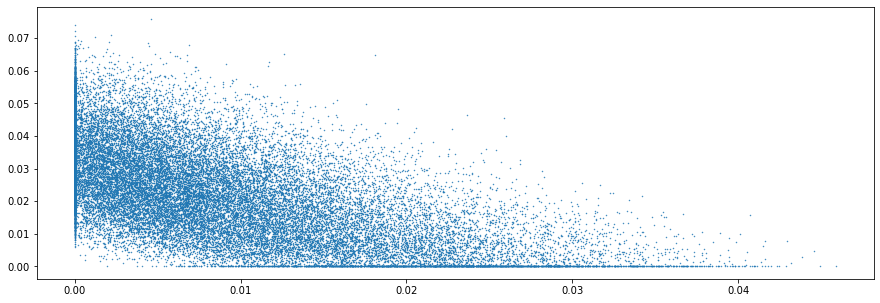

In [50]:
K = 2

model = NMF(n_components=int(K), init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

plt.figure(figsize=(15,5))
plt.scatter(W[:,0], W[:,1], s=0.2)
plt.show()

**Latent Semantic Analysis (LSA)**

[Dimensionality reduction using truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) is a decomposition method used for linear dimensionality reduction. It is generally known as LSA.

> SVD deals with decomposing a matrix into a product of 3 matrices as shown: A=USV^T
> [Mahendru (2019)](https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/)


Based on Kobayashi et.al. (2019) `n_components` should be calculated by `K = N * (1 / (1+ (log(N) / 10)))` `N`: size of corpus and `K`: number of dimensions to retain.

Based on sklearn a recommended value for `n_components` is 100.

In [74]:
K = 100

In [23]:
N = X.shape[0]
K = N * (1 / (1+ (math.log10(N))))
print('K should be approximately', K)

K should be approximately 5993.559207740943


In [72]:
from sklearn.decomposition import TruncatedSVD

begin = time.time()

lsa = TruncatedSVD(n_components=int(K), random_state=42)
X_new = lsa.fit_transform(X)

time.sleep(1)
end = time.time()
time_passed = end - begin

print('Time with k = {}:{:<5} {:.3f} ms'.format(K, '', time_passed))

Time with k = 2:      1.843 ms


Outputs for different *K*:

`Time with K = 2:      1.640 s`

`Time with K = 100:    7.488 s`

`Time with K = 5993:   1084.439 s`

Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

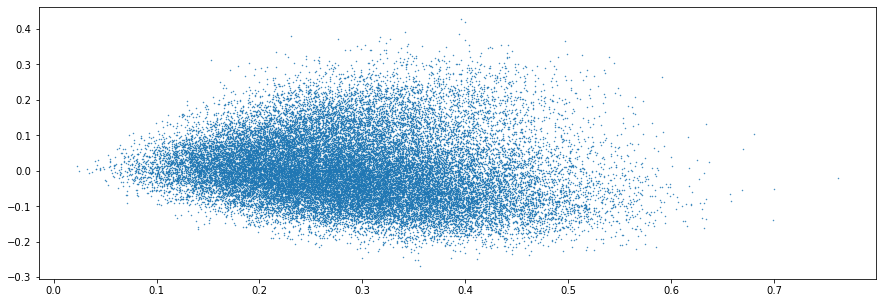

In [52]:
K = 2

lsa = TruncatedSVD(n_components=int(K), random_state=42)
X_new = lsa.fit_transform(X)

plt.figure(figsize=(15,5))
plt.scatter(X_new[:,0], X_new[:,1], s=0.2)
plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.tokenizer import BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer
from academia_tag_recommender.vectorizer_computation import get_vect_feat_with_params
from academia_tag_recommender.documents import documents as get_documents
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

documents = get_documents()
texts = [document.text for document in documents]

[vectorizer, features] = get_vect_feat_with_params(texts, TfidfVectorizer, BasicTokenizer, BasicPreprocessor, 'yes', (1, 1))

label = [document.tags for document in documents]

X = features
print('X data with shape {}'.format(X.shape))

y = MultiLabelBinarizer().fit_transform(label)
print('Y data with shape {}'.format(y.shape))

N = X.shape[0]
K = N * (1 / (1+ (math.log10(N))))
print('K should be approximately', K)

lsa = TruncatedSVD(n_components=int(K), random_state=42)
X_new = lsa.fit_transform(X)
path = data_folder / 'tfidf_basic_tokenizer_basic_preprocessor_english_1_1.joblib'
dump([lsa, X_new], path)

Received saved model
X data with shape (33082, 21938)
Y data with shape (33082, 452)
K should be approximately 5993.559207740943


['c:\\users\\monique\\masterthesis\\academia_tag_recommender\\models\\dimension_reduction\\tfidf_basic_tokenizer_basic_preprocessor_english_1_1.joblib']